In [ ]:
import numpy as np
import pandas as pd
import time
import cv2
import threading

In [ ]:
def auto_canny(gray, sigma=0.33):
    # compute the median of the single channel pixel intensities
    edged = np.zeros((260,680),np.uint8)
    for j in range(0,680,40) :
        for i in range(0,260,40):
            image = gray[i:i+40,j:j+40]
            v = int(np.mean(image))
            # apply automatic Canny edge detection using the computed median
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
#             print(lower,upper)
            edged[i:i+40,j:j+40] = cv2.Canny(image, 40, v+40)
    return edged

In [ ]:
def hod_rd_sub1(meanhls,meanc):
    for i in range(my,shape[1]-lmd,lmd-2):
        ver_rd(i,meanhls,meanc)

In [ ]:
def hod_rd_sub2(mean1hls,mean1c):
    for i in range(my+lmd,0, -(lmd-2)):
        ver_rd(i,mean1hls,mean1c)

In [ ]:
def hor_rd(meanhls,meanc):
    hod_rd_sub1(meanhls,meanc)
    hod_rd_sub2(meanhls,meanc)

In [ ]:
def ver_rd(x,meanhls,meanc):
    lm1 = lim1
    lm2 = lim2
    lmc = limc
    for i in range(mx,lmd+1,-(lmd-10)):
        lm1 += lm1*0.01
        lm2 += lm2*0.01
        lmc += limc*0.02
        lowhls = meanhls - [0,lm1,lm2]
        highhls = meanhls + [180,lm1,lm2]
        lowc = meanc - lmc
        highc = meanc + lmc
        newscr[i-lmd:i, x:x+lmd] =  cv2.inRange(scr[i-lmd:i, x:x+lmd],lowc,highc)#cv2.inRange(hls[i-lmd:i, x:x+lmd],lowhls,highhls)#+
        
        reshls = [0]+[np.mean(hls[i-lmd:i, x:x+lmd,j]) for j in range(1,3)]
        reshls = np.array(reshls)
        
        resc = [np.mean(scr[i-lmd:i, x:x+lmd,j]) for j in range(3)]
        resc = np.mean(resc)
        
        if(abs(reshls[1]-meanhls[1])<=15 and abs(reshls[2]-meanhls[2])<=15):
            meanhls = (4*reshls+6*meanhls)/10
        
        
        if resc <= 0.8*np.mean(highc) and resc >= 0.8*np.mean(lowc):
            meanc = (5*resc+5*meanc)/10
      

In [ ]:
import numpy as np
import pandas as pd
import time
import cv2
import threading
# lim = 4*std
lmd = 50
lim1 = lim2 = 10
limc = 30
kernel = np.ones((3,3),np.uint8)

shape = [480,680]#scr.shape
scr2 = 0
mx = shape[0] - 220
my = shape[1]//2
print("running")
kkk = 300*8*2
mask_prev1 = np.zeros((shape[0]-220,shape[1]),np.uint8)
mask_prev2 = np.zeros((shape[0]-220,shape[1]),np.uint8)
mean_prev_hls = 0
mean_prev_c = 0
vrec = cv2.VideoCapture('v4.mp4',0)

last = None

while(kkk):
    ret, scr = vrec.read()
    kkk-=1

while True: 
    start_time = time.time()
    blank = cv2.imread('blank.png', 0)
    blank = cv2.resize(blank,(680,260))
    ret, scr = vrec.read()
    if not ret:
            break
    scr = cv2.resize(scr, (680,480)) 
    scr = np.array(scr[220:480,:])
    cv2.imshow('scr1',scr)
    
    frame = cv2.GaussianBlur(scr, (3, 3), 0)
    frame = cv2.GaussianBlur(scr, (5, 5), 0)
    scr = cv2.addWeighted(scr,10,frame,-9,0)
#     frame = cv2.GaussianBlur(scr, (5, 5), 0)
#     scr = cv2.addWeighted(scr,2,frame,-1,0)
#     frame = cv2.GaussianBlur(scr, (5, 5), 0)
#     scr = cv2.addWeighted(scr,1.7,frame,-1,0)
#     frame = cv2.GaussianBlur(scr, (5, 5), 0)
#     scr = cv2.addWeighted(scr,1.7,frame,-0.7,0)
   
    cv2.imshow('scred',scr)
    hls = cv2.cvtColor(scr, cv2.COLOR_BGR2HLS)
    gray = cv2.cvtColor(scr, cv2.COLOR_BGR2GRAY)
    mean1 = np.mean(gray[440-220:480-220,200:480])
    mean1 = np.array(mean1)
    low1 = mean1 - 10
    high1 = mean1 + 1
    
    canny = cv2.Canny(gray,min(50,mean1-1),high1)
    canny = blank-canny

    im2, contours, hierarchy = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    scr = cv2.drawContours(scr, contours, -1, 0, 1)
    blank = cv2.drawContours(blank, contours, -1, 0, 1)
    dist_transform = cv2.distanceTransform(canny,cv2.DIST_L2,5)
    ret, blank = cv2.threshold(dist_transform,0.02*dist_transform.max(),255,0)
#     blank = cv2.dilate(blank,kernel,iterations = 2)
    blank = cv2.morphologyEx(blank, cv2.MORPH_OPEN, kernel,5)
#     scr = np.multiply(scr,blank) 
    cv2.imshow("edge normal canny", scr)
    cv2.imshow("blankobj",blank)
    
    scr1 = scr
    scr2 = scr
    newscr = np.zeros((shape[0]-220,shape[1]),np.uint8)
    

###   HLS
    hls = cv2.cvtColor(scr, cv2.COLOR_BGR2HLS)
    meanhls = [0]+[np.mean(hls[440-220:480-220,200:480, i]) for i in range(1,3)]
    std = [np.std(hls[440-220:480-220,200:480, i]) for i in range(1,3)]
    lim1 = (lim1 + 16*std[0])/5  #(1:4(4))/5
    lim2 = (lim2 + 16*std[1])/5
#     print(lim1,lim2)
    meanhls = np.array(meanhls)
    meanhls = 0.3*meanhls + mean_prev_hls*0.7
    mean_prev_hls = meanhls


#### RGB
    meanc = [np.mean(scr[440-220:480-220,200:480, i]) for i in range(3)]
    meanc = np.array(meanc)
    meanc = 0.2*meanc + mean_prev_c*0.8
    mean_prev_c = meanc

####
    hor_rd(meanhls,meanc)


    cv2.imshow('newscr',newscr)
    mask3 = newscr #+ mask1
    mask4 = mask_prev1 + mask3 
    mask_prev1 = mask3 
    
#     dist_transform = cv2.distanceTransform(mask4,cv2.DIST_L2,5)
#     ret, mask4 = cv2.threshold(dist_transform,0.03*dist_transform.max(),255,0)

    cv2.imshow('band4',mask4)
    mask4 = np.uint8(blank)
    
    im2, contours, hierarchy = cv2.findContours(mask4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
#     for i in range(len(contours)):
#         epsilon = 0.003*cv2.arcLength(contours[i], True)
#         contours[i] = cv2.approxPolyDP(contours[i], epsilon, True)
#             for k in range(len(contours[i])):
#                 [point.append([i,j] for i incontours[i][k][0][0]:contours[i][k+1][0][0], contours[i][k][0][1]:contours[i][k+1][0][1]]
                
#             print(len(contours[i]))
#     last = contours
        
    
#     cv2.line(scr2,(0,480),(340,240),(255,255,0),2)
#     cv2.line(scr2,(680,480),(340,240),(255,255,0),2)

#     cv2.imshow('band4',mask4)
#     scr = cv2.drawContours(scr, contours, -1,[0,255,255], 3)
#     cv2.imshow('print',scr)
#     cv2.imshow('blank',blank)



#     cv2.line(scr2,(0, 480),(340, int(220)),(0, 255, 255), 1)
#     cv2.line(scr2,(680, 480),(340, int(220)),(0, 255, 255), 1)
    
#     cv2.line(scr2,(0,int(220)),(680,int(220)),(0,0,255),2)#216  220
    
#     for ind in range(0,260+20,20):
#         xx = (ind)*2
#         cv2.putText(scr2,str(xx),(10,480-ind), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),1,cv2.LINE_AA)
#         cv2.line(scr2,(0,480-ind),(680,480-ind),(0,255,255),1)

    print("FPS: ", 1.0 / (time.time() - start_time))
    q=cv2.waitKey(1)
    if q == 27:
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()

In [ ]:
import numpy as np
import pandas as pd
import time
import cv2
import threading

vrec = cv2.VideoCapture('v2.mp4',0)
shape = [480,680]

mx = shape[0]
my = shape[1]//2
print("running")
kkk = 300*6*6
while(kkk):
    kkk-=1
    ret, scr = vrec.read()

ret, scr1 = vrec.read()
scr1 = cv2.resize(scr1, (680,480)) 
scr1 = cv2.cvtColor(scr1, cv2.COLOR_BGR2GRAY)
ret, scr2 = vrec.read()
scr2 = cv2.resize(scr2, (680,480)) 
scr2 = cv2.cvtColor(scr2, cv2.COLOR_BGR2GRAY)
while True:
    start_time = time.time()
    scr = scr1
    scr1 = scr2
    ret, scr2 = vrec.read()
#     ret, scr3 = vrec.read()
#     scr = np.mean(scr1,scr2,scr3)
    if not ret:
            break
    scr2 = cv2.resize(scr2, (680,480)) 
    scr2 = cv2.cvtColor(scr2, cv2.COLOR_BGR2GRAY)
    
    d0 = abs(scr1-scr)
    d1 = abs(scr2-scr)
    d2=d0+d1
    
    cv2.imshow('d0',d0)
    cv2.imshow('d1',d1)
    cv2.imshow('d2',d2)
#     cv2.imshow('d3',d3)
#     cv2.imshow('d4',d4)

    cv2.imshow('scr1',scr)
    print("FPS: ", 1.0 / (time.time() - start_time))
    q=cv2.waitKey(1)
    if q == 27:
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()

In [ ]:
img = cv2.imread("c1.png",cv2.IMREAD_GRAYSCALE)
resize_pic=img
#resize_pic=cv2.resize(img,(640,480),interpolation=cv2.INTER_CUBIC)
edges = cv2.Canny(resize_pic,50,150)
lines_data = cv2.HoughLines(edges,1,np.pi/180,150)
# cv2.imshow('img',lines_data)
print(lines_data)
cv2.imshow('img3',resize_pic )

In [ ]:
cv2.destroyAllWindows()

In [ ]:
import numpy as np
import pandas as pd
import time
import cv2
import threading
# import keras
import skimage.measure
# lim = 4*std
lmd = 40
lim1 = lim2 = 10
limc = 25
kernel = np.ones((3,3),np.uint8)

shape = [480,680]#scr.shape
scr2 = 0
mx = shape[0] - 220
my = shape[1]//2
print("running")
kkk = 300*8*2
mask_prev1 = np.zeros((shape[0]-220,shape[1]),np.uint8)
mask_prev2 = np.zeros((shape[0]-220,shape[1]),np.uint8)
mean_prev_hls = 0
mean_prev_c = 0
vrec = cv2.VideoCapture('v4.mp4',0)

while(kkk):
    ret, scr = vrec.read()
    kkk-=1

while True: 
    start_time = time.time()
    blank = cv2.imread('blank.png', 0)
    blank = cv2.resize(blank,(680//2,260//2))
    #ret, 
    scr =cv2.imread('c2.jpg', 1) #vrec.read()
    if not ret:
            break
#     keras.layers.Conv2D(scr, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), use_bias=True, kernel_initializer='glorot_uniform')   
#     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
    scr = cv2.resize(scr, (680,480)) 
    scr = np.array(scr[220:480,:])

    cv2.imshow('scr1',scr)
    x = 340
    y = 130
    scr = cv2.resize(scr, (x,y)) 
#     scr = skimage.measure.block_reduce(scr,(2,2,3), np.max)
    cv2.imshow('scr2',scr)
    hls = cv2.cvtColor(scr, cv2.COLOR_BGR2HLS)
    gray = cv2.cvtColor(scr, cv2.COLOR_BGR2GRAY)
    mean1 = np.mean(gray[440//2-220//2:480//2-220//2,200//2:480//2])
    mean1 = np.array(mean1)
    low1 = mean1 - 10
    high1 = mean1 + 1
    
    canny = cv2.Canny(gray,min(50,mean1-1),high1)
    canny = blank-canny

    im2, contours, hierarchy = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    scr = cv2.drawContours(scr, contours, -1, 0, 1)
    blank = cv2.drawContours(blank, contours, -1, 0, 1)
#     dist_transform = cv2.distanceTransform(canny,cv2.DIST_L2,5)
#     ret, blank = cv2.threshold(dist_transform,0.07*dist_transform.max(),255,0)
# #     blank = cv2.dilate(blank,kernel,iterations = 2)
#     blank = cv2.morphologyEx(blank, cv2.MORPH_OPEN, kernel,5)
#     scr = np.multiply(scr,blank) 
    cv2.imshow("edge normal canny", scr)
    cv2.imshow("blankobj",blank)
    
    scr1 = scr
    scr2 = scr
    newscr = np.zeros((shape[0]-220,shape[1]),np.uint8)
    

###   HLS
    hls = cv2.cvtColor(scr, cv2.COLOR_BGR2HLS)
    meanhls = [0]+[np.mean(hls[440//2-220//2:480//2-220//2,200//2:480//2, i]) for i in range(1,3)]
    std = [np.std(hls[440//2-220//2:480//2-220//2,200//2:480//2, i]) for i in range(1,3)]
    lim1 = (lim1 + 16*std[0])/5  #(1:4(4))/5
    lim2 = (lim2 + 16*std[1])/5
#     print(lim1,lim2)
    meanhls = np.array(meanhls)
    meanhls = 0.3*meanhls + mean_prev_hls*0.7
    mean_prev_hls = meanhls


#### RGB
    meanc = [np.mean(scr[440//2-220//2:480//2-220//2,200//2:480//2, i]) for i in range(3)]
    meanc = np.array(meanc)
    meanc = 0.2*meanc + mean_prev_c*0.8
    mean_prev_c = meanc

####
#     hor_rd(meanhls,meanc)


#     cv2.imshow('newscr',newscr)
#     mask3 = newscr #+ mask1
#     mask4 = mask_prev1 + mask3 
#     mask_prev1 = mask3 
    
#     dist_transform = cv2.distanceTransform(mask4,cv2.DIST_L2,5)
#     ret, mask4 = cv2.threshold(dist_transform,0.03*dist_transform.max(),255,0)

#     cv2.imshow('band4',mask4)
    mask4 = np.uint8(blank)
    
    im2, contours, hierarchy = cv2.findContours(mask4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
#     for i in range(len(contours)):
#         epsilon = 0.003*cv2.arcLength(contours[i], True)
#         contours[i] = cv2.approxPolyDP(contours[i], epsilon, True)
#             for k in range(len(contours[i])):
#                 [point.append([i,j] for i incontours[i][k][0][0]:contours[i][k+1][0][0], contours[i][k][0][1]:contours[i][k+1][0][1]]
                
#             print(len(contours[i]))
#     last = contours
        
    
#     cv2.line(scr2,(0,480),(340,240),(255,255,0),2)
#     cv2.line(scr2,(680,480),(340,240),(255,255,0),2)

#     cv2.imshow('band4',mask4)
#     scr = cv2.drawContours(scr, contours, -1,[0,255,255], 3)
#     cv2.imshow('print',scr)
#     cv2.imshow('blank',blank)



#     cv2.line(scr2,(0, 480),(340, int(220)),(0, 255, 255), 1)
#     cv2.line(scr2,(680, 480),(340, int(220)),(0, 255, 255), 1)
    
#     cv2.line(scr2,(0,int(220)),(680,int(220)),(0,0,255),2)#216  220
    
#     for ind in range(0,260+20,20):
#         xx = (ind)*2
#         cv2.putText(scr2,str(xx),(10,480-ind), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),1,cv2.LINE_AA)
#         cv2.line(scr2,(0,480-ind),(680,480-ind),(0,255,255),1)

    print("FPS: ", 1.0 / (time.time() - start_time))
    q=cv2.waitKey(1)
    if q == 27:
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import argparse
# import utils
import cv2
 

ap = argparse.ArgumentParser()
ap.add_argument("-c", "--clusters", required = True, type = int, help = "# of clusters")
args = vars(ap.parse_args())
 
image = cv2.imread('c1.png',1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
# show our image
plt.figure()
plt.axis("off")
plt.imshow(image)

In [ ]:
# image = image.reshape((image.shape[0] * image.shape[1], 3))
clt = KMeans(n_clusters = 3)
clt.fit(image)

In [ ]:
import numpy as np
import cv2
 
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

In [ ]:

def plot_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0
 
	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar

In [ ]:
# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color
hist = utils.centroid_histogram(clt)
bar = utils.plot_colors(hist, clt.cluster_centers_)
 
# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

x = np.random.randint(25,100,25)
y = np.random.randint(175,255,25)
z = np.hstack((x,y))
z = z.reshape((50,1))
z = np.float32(z)
plt.hist(z,256,[0,256]),plt.show()
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS

# Apply KMeans
compactness,labels,centers = cv2.kmeans(z,2,None,criteria,10,flags)
A = z[labels==0]
B = z[labels==1]
# Now plot 'A' in red, 'B' in blue, 'centers' in yellow
plt.hist(A,256,[0,256],color = 'r')
plt.hist(B,256,[0,256],color = 'b')
plt.hist(centers,32,[0,256],color = 'y')
plt.show()


In [ ]:
from skimage import io
from sklearn.cluster import KMeans
import numpy as np

image = io.imread('c1.png')
io.imshow(image)
io.show()

rows = image.shape[0]
cols = image.shape[1]
 
image = image.reshape(image.shape[0]*image.shape[1],3)
kmeans = KMeans(n_clusters = 128, n_init=10, max_iter=200)
kmeans.fit(image)

clusters = np.asarray(kmeans.cluster_centers_,dtype=np.uint8) 
labels = np.asarray(kmeans.labels_,dtype=np.uint8 )  
labels = labels.reshape(rows,cols); 

np.save('codebook_tiger.npy',clusters.imsave('compressed_tiger.png',labels))

In [ ]:
import numpy as np
import cv2
cap = cv2.VideoCapture('720p.mp4')
ret,frame = cap.read()
# setup initial location of window
r,h,c,w = 0,0,50,50  # simply hardcoded the values
track_window = (c,r,w,h)
# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
# mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
# cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 12, 0 )
kkk = 300*8*6
while(kkk):
    ret, scr = cap.read()
    kkk-=1
while(1):
    ret ,frame = cap.read() 
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        print(dst)
        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        cv2.imshow('img2',img2)
    
        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)
    else:
        break
cv2.destroyAllWindows()
cap.release()

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

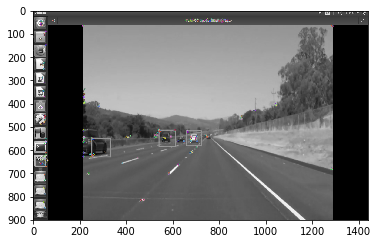

(<matplotlib.image.AxesImage at 0x124367160>, None)

In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('c1.png',0)

is_v2 = cv2.__version__.startswith("2.")
if is_v2:
    detector = cv2.SimpleBlobDetector()
else:
    detector = cv2.SimpleBlobDetector_create()

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(img,None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, img)
# img2 = cv2.drawKeypoints(img,kp)#,color=(0,255,0), flags=0)
# kp = detector.detect(img)
plt.imshow(img2),plt.show()

In [19]:
import cv2
img=cv2.imread('c1.png',1)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift=cv2.xfeatures2d.SIFT_create()
kp=sift.detect(gray,None)
img=cv2.drawKeypoints(gray, kp, img)
cv2.imshow('img',img)
k = cv2.waitKey(60) & 0xff
if k == 27:
    cv2.destroyAllWindows()